Reinforcement Learning Assignment

Group: 07

Authors: Paul Bonnie, Nicolas Forcella, Zheyan Lin, Tijmen Westeneng

# 0 - Instructions
This jupyter notebook is intended to be run sequantially. Start by instaling the necessary packages and importing the packages.
For every algorithm the code is presented along with an example on how to run it. Optionally, the resulting policy can be run in render mode for evaluation. 
For running the MC and TD algorithms correctly policy iteration must be run first since we use it's values as ground truth.

# 1 - Setup

## 1.1 Install requirements

In [1]:
!pip install pygame
!pip install numpy
!pip install gymnasium
!pip install tqdm

## 1.2 Import required packages

In [2]:
import numpy as np
import random
import pygame
import gymnasium as gym
from gymnasium import spaces
from gymnasium.utils import seeding
from gymnasium.envs.toy_text.utils import categorical_sample
from typing import List, Optional
import matplotlib.pyplot as plt
from tqdm import tqdm

pygame 2.6.1 (SDL 2.28.4, Python 3.12.4)
Hello from the pygame community. https://www.pygame.org/contribute.html


# 2 - Environment definition
In this section we define the class ZombieEscapeEnv that inherits the properties from gymnasium.Env and implements our zombie grid. This class represents the MDP dynamics.

**Note:** In order for the render mode to work make sure to run the Jupyter notebook in the same directory as the img folder uploaded with the project.

In [3]:
LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3

class ZombieEscapeEnv(gym.Env):
    metadata = {"render_modes": ["human", "ansi"], "render_fps": 4}

    def __init__(self, render_mode=None, size=8, fixed_seed: Optional[int] = None, gamma=1):
        super(ZombieEscapeEnv, self).__init__()
        #store grid size
        self.grid_size = size
        self.fixed_seed = fixed_seed
        #PYGAME INITIALIZATIONS
        #only load this if needed
        if render_mode == 'human':
            self.window_size = 512  # The size of the PyGame window
            self.brain_img = pygame.image.load("./img/brain.png")  # Brain
            self.grass_img = pygame.image.load("img/grass.jpeg")  # grass
            self.spikeweed_img = pygame.image.load("./img/spikeweed.png")  # spikeweed
            self.plant_img = pygame.image.load("./img/plant.png")  # plant
            self.zombie_img = pygame.image.load("./img/zombie.png")  # zombie
            self.house_img = pygame.image.load("./img/house.png")  # house

            #Resize images to fit grid size
            self.cell_size = self.window_size // self.grid_size
            self.brain_img = pygame.transform.scale(self.brain_img, (self.cell_size, self.cell_size))
            self.grass_img = pygame.transform.scale(self.grass_img, (self.cell_size, self.cell_size))
            self.spikeweed_img = pygame.transform.scale(self.spikeweed_img, (self.cell_size, self.cell_size))
            self.plant_img = pygame.transform.scale(self.plant_img, (self.cell_size, self.cell_size))
            self.zombie_img = pygame.transform.scale(self.zombie_img, (self.cell_size, self.cell_size))
            self.house_img = pygame.transform.scale(self.house_img, (self.cell_size, self.cell_size))
        
        assert render_mode is None or render_mode in self.metadata["render_modes"]
        self.render_mode = render_mode

        """
        If human-rendering is used, `self.window` will be a reference
        to the window that we draw to. `self.clock` will be a clock that is used
        to ensure that the environment is rendered at the correct framerate in
        human-mode. They will remain `None` until human-mode is used for the
        first time.
        """
        self.window = None
        self.clock = None

        #ACTUAL GAME INITIALIZATIONS
        self.r_map = self.generate_random_map(seed=self.fixed_seed)
        self.nrow, self.ncol = nrow, ncol = self.r_map.shape
        self.gamma = gamma
        nA = 4  # actions
        nS = nrow * ncol  # states

        # Create tuples inside the dictionary for each cell, to store information like this:
        # (transition probability, next state, reward, terminated)
        self.P = {s: {a: [] for a in range(nA)} for s in range(nS)}

        self.s = 0
        if self.render_mode == "human":
            self._render_frame()

        # Change the position of the agent to an index
        def to_s(row, col):
            return row * ncol + col

        # Constrain the movement of zombie so it doesn't go out of index
        def inc(row, col, a):
            if a == LEFT:
                col = max(col - 1, 0)
            elif a == DOWN:
                row = min(row + 1, nrow - 1)
            elif a == RIGHT:
                col = min(col + 1, ncol - 1)
            elif a == UP:
                row = max(row - 1, 0)
            return (row, col)

        # define the reward and new states after action so it can be filled in self.P
        def update_probability_matrix(row, col, action):
            new_row, new_col = inc(row, col, action)
            new_state = to_s(new_row, new_col)
            new_letter = self.r_map[new_row, new_col]
            terminated = new_letter in "CD"
            reward = self.get_reward(new_letter)
            
            return new_state, reward, terminated

        # Fill in self.P
        probability_table = [0.1, 0.8, 0.1]
        for row in range(nrow):
            for col in range(ncol):
                s = to_s(row, col)
                for a in range(4):
                    li = self.P[s][a]
                    letter = self.r_map[row, col]
                    # if current state is "C" or "D", game over
                    if letter in "CD":
                        li.append((1.0, s, 0, True))
                    else:
                        # for other state, for each action, the probability of going in the right direction
                        # is 0.8, going in the correct direction's left/right's probability is 0.1
                        for i, b in enumerate([(a - 1) % 4, a, (a + 1) % 4]):
                            li.append((probability_table[i], *update_probability_matrix(row, col, b)))

        self.observation_space = spaces.Discrete(nS)
        self.action_space = spaces.Discrete(nA)

    def get_gamma(self):
        return self.gamma
    
    def is_valid(self, board: List[List[str]], max_size: int) -> bool:
        # use simple dfs to track there's a valid path from start to Dave's house
        frontier, discovered = [], set()
        frontier.append((0, 0))
        while frontier:
            r, c = frontier.pop()
            if not (r, c) in discovered:
                discovered.add((r, c))
                directions = [(1, 0), (0, 1), (-1, 0), (0, -1)]
                for x, y in directions:
                    r_new = r + x
                    c_new = c + y
                    # exceeding the index
                    if r_new < 0 or r_new >= max_size or c_new < 0 or c_new >= max_size:
                        continue
                    # Dave's house
                    if board[r_new][c_new] == "D":
                        return True
                    # To avoid zombie being devoured by the chompers
                    if board[r_new][c_new] != "C":
                        frontier.append((r_new, c_new))
        return False

    def generate_random_map(
            self, size: int = 8, seed: Optional[int] = None
    ) -> np.array:
        """Generates a random valid map (one that has a path from start to Dave's house)

        Args:
            size: size of each side of the grid
            seed: optional seed to ensure the generation of reproducible maps

        Returns:
            A random valid map
        """
        valid = False
        board = []  # initialize to make pyright happy
        p1 = 0.7
        p2 = 0.1
        p3 = 0.1
        p4 = 0.1

        np_random, _ = seeding.np_random(seed if seed is not None else self.fixed_seed)

        while not valid:
            board = np_random.choice(["L", "W", "C", "B"], (size, size), p=[p1, p2, p3, p4])
            board[0][0] = "S"
            board[-1][-1] = "D"
            valid = self.is_valid(board, size)
        return board

    def step(self, a):
        transitions = self.P[self.s][a]
        i = categorical_sample([t[0] for t in transitions], self.np_random)  # choose the next move based on the probability table of this action
        p, s, r, t = transitions[i]
        self.s = s
        self.lastaction = a

        # truncation=False as the time limit is handled by the `TimeLimit` wrapper added during `make`
        return int(s), r, t, False, {"prob": p}
    
    
    def _get_agent_location(self):
        #convert state to row, column
        return self.convert_state_to_table_index(self.s)
    
    def convert_state_to_table_index(self, state):
        return state // self.grid_size, state % self.grid_size
    
    def get_reward(self, letter):
        # decide reward
        reward:float
        if letter == "B":
            reward = 0.5
        elif letter == "W":
            reward = -0.5
        elif letter == "D":
            reward = 100
        elif letter == "C":
            reward = -1000  
        else:
            reward = -1
        
        return reward
    
    def get_letter(self, state):
        row, column =  self.convert_state_to_table_index(state)
        return self.r_map[row, column]
    
    def get_state_reward(self, state):
        letter = self.get_letter(state)
        return self.get_reward(letter)

    def get_current_state(self):
        return self.s
    
    def reset(self, *, seed: Optional[int] = None, options: Optional[dict] = None, ):
        #super().reset(seed = seed if seed is not None else self.fixed_seed)
        self.s = 0
        return int(self.s)

        # Initialize the state
        # self.state = self.get_state()

    def _render_frame(self):
        if self.window is None and self.render_mode == "human":
            pygame.init()
            pygame.display.init()
            self.window = pygame.display.set_mode((self.window_size, self.window_size))
        if self.clock is None and self.render_mode == "human":
            self.clock = pygame.time.Clock()

        canvas = pygame.Surface((self.window_size, self.window_size))
        canvas.fill((255, 255, 255))
        pix_square_size = (
            self.window_size / self.grid_size
        )  # The size of a single grid square in pixels

        # First we draw the house
        target_x, target_y = (self.grid_size - 1, self.grid_size - 1)
        canvas.blit(self.house_img, (target_x * pix_square_size, target_y * pix_square_size))

        #Draw the rest of the objects
        for row in range(self.r_map.shape[0]):
            for col in range(self.r_map.shape[1]):
                letter = self.r_map[col, row]
                match letter:
                    case 'B':
                        canvas.blit(self.grass_img, (row * pix_square_size, col * pix_square_size))
                        canvas.blit(self.brain_img, (row * pix_square_size, col * pix_square_size))
                    case 'L':
                        canvas.blit(self.grass_img, (row * pix_square_size, col * pix_square_size))
                    case 'C':
                        canvas.blit(self.grass_img, (row * pix_square_size, col * pix_square_size))
                        canvas.blit(self.plant_img, (row * pix_square_size, col * pix_square_size))
                    case 'W':
                        canvas.blit(self.grass_img, (row * pix_square_size, col * pix_square_size))
                        canvas.blit(self.spikeweed_img, (row * pix_square_size, col * pix_square_size))
       
        # Now we draw the agent
        agent_y, agent_x  = self._get_agent_location()
        canvas.blit(self.zombie_img, (agent_x * pix_square_size, agent_y * pix_square_size))

        # Finally, add some gridlines
        for x in range(self.grid_size + 1):
            pygame.draw.line(
                canvas,
                0,
                (0, pix_square_size * x),
                (self.window_size, pix_square_size * x),
                width=3,
            )
            pygame.draw.line(
                canvas,
                0,
                (pix_square_size * x, 0),
                (pix_square_size * x, self.window_size),
                width=3,
            )

        if self.render_mode == "human":
            # The following line copies our drawings from `canvas` to the visible window
            self.window.blit(canvas, canvas.get_rect())
            pygame.event.pump()
            pygame.display.update()

            # We need to ensure that human-rendering occurs at the predefined framerate.
            # The following line will automatically add a delay to
            # keep the framerate stable.
            self.clock.tick(self.metadata["render_fps"])
        else:  # rgb_array
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(canvas)), axes=(1, 0, 2)
            )
        
    def render(self):
        # Print the board by placing the agent at the specified position"""
        if self.render_mode == 'human':
            return self._render_frame()
        
        if self.render_mode == 'ansi':
            agent_row, agent_col = int(self.s) // self.grid_size, int(self.s) % self.grid_size
            r_map_copy = self.r_map.copy()
            r_map_copy[agent_row, agent_col] = 'Z'  # Place agent at the specified position
            for row in r_map_copy:
                print("".join(row for row in row))
            print("")

    def is_terminal(self, state=None):
        if state == None:
          state = self.s

        # Check current state to see if it is terminal
        agent_row, agent_col = int(state) // self.grid_size, int(state) % self.grid_size
        r_map_copy = self.r_map.copy()
        letter = r_map_copy[agent_row, agent_col]
        if letter in 'CD':
            return True
        return False


    def generate_episode(self, policy, initial_state=0, initial_action = None, max_steps = 50):
        """
        Sample an episode from the env following a policy. (Start at state 0 unless the intial state is specified)
        """

        state = initial_state
        self.s = initial_state
        episode = []
        if initial_action == None:
            action = policy[state]
        else:
            action = initial_action
        terminal = False
        steps = 0
        truncated = False

        while not terminal and steps < max_steps: # Generate episodes where the actions are performed following the policy until in a terminal state
            
            next_state, reward, terminal, _, _ = self.step(action)
            episode.append((state, action, reward))
            
            state = next_state
            action = policy[state]
            steps += 1
        
        if steps >= max_steps:
            truncated = True

        return episode, truncated

    
    def close(self):
        if self.window is not None:
            pygame.display.quit()
            pygame.quit()
            self.window = None
            self.clock = None  # Reset clock too

In [4]:
#function for running the environment with a policy
def run_environment(environment, policy=None):
    environment.render_mode = "human"
    state = environment.reset()
    terminal = False

    while not terminal:
        action = environment.action_space.sample() if policy is None else policy[state]
        next_state, reward, terminal = environment.step(action)[:3]
        environment.render()
        state = next_state
    environment.close()

## Example usage
The following block of code will randomly move the agent through the environment until it reaches a terminal state.

In [5]:
#Instanciate the class with gamma, a fixed_seed for reproducibility and render mode
#For render mode use human for visualization and None for training.
env = ZombieEscapeEnv(render_mode="human", fixed_seed = 71, gamma=0.93)
run_environment(env)

# 3 - Learning Algorithms

## 3.1 Base Class
The following class implements the base class for our learining algorithms, it includes initialization of some common properties and methods used throughout the project (for example, visualization functions). On top of this, it ensures consistency on the way the code is run across algorithms. All algorithms are run by calling the get_training_results method which calls the run_training method if the algorithm has not been already trained or just returns the results if it has.

All child classes must override the parent's run_training method.

In [6]:
class LearningAlgorithm:
    """
    This class represents the base case for a learning algorithm. It contains methods shared by all algorithms such as getters and plotting.
    """
    def __init__(self, zombie_environment:ZombieEscapeEnv, episodes = None, target_values = None):
        #INITIALIZE CLASS VAR
        self.trained = False
        self.value_function = None
        self.policy = None
        #INITIALIZE ENVIRONMENT VALUES
        self.zombie_environment = zombie_environment
        self.number_of_actions = zombie_environment.action_space.n
        self.number_of_states = zombie_environment.observation_space.n
        self.gamma = self.zombie_environment.get_gamma()

        # Target values and error array for RMSE calculations and plotting
        if episodes is not None and target_values is not None:
            self.episodes = episodes
            self.target_values = target_values
            self.errors = np.zeros(episodes)

        # Initialize list consisting of tuples of episode number and cumulative reward for that episode
        self.cum_reward_list = []

    def __repr__(self):
        return type(self).__name__

    def run_training(self):
        pass

    def get_training_results(self):
        #If model has not been trained
        if not self.trained:
            self.run_training()
            self.trained = True
        
        return self.value_function, self.policy
    
    def visualise_policy(self):
        """
        Plots the policy on an 8x8 grid. For each state an arrow is plotted in the direction 
        specified by the policy. For terminal states, the name of the terminal state, e.g. Chomper,
        is plotted instead of an arrow.
        """
        policy_matrix = self.policy.reshape(8,8)

        arrows = {0:(-1,0), 1:(0,-1), 2:(1,0), 3:(0,1)} # For each action, we define the x and y direction of the arrow (e.g., for action 0, i.e. left, the arrow should point in direction (-1, 0))
        scale = 0.3

        fig, ax = plt.subplots(figsize=(8,8))
        ax.set_xlim(-0.5, 7.5)
        ax.set_ylim(-0.5, 7.5)
        ax.set_xticks(np.arange(8) - 0.5)
        ax.set_yticks(np.arange(8) - 0.5)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.grid(True, linestyle='--', color='gray', alpha=0.5)

        for r in range(8):
            for c in range(8):
                state_id = r * 8 + c
                # Check if the state is terminal, if yes plot an arrow, if no plot a T
                if not self.zombie_environment.is_terminal(state_id):
                    action = policy_matrix[r, c]
                    dx, dy = arrows[action] # Get the arrow x and y directions
                    ax.arrow(c, 7 - r, dx * scale, dy * scale, head_width=0.2, head_length=0.2, fc='blue', ec='blue') # create an arrow for the cell 
                elif self.zombie_environment.get_letter(state_id) == "C":
                    ax.text(c, 7 - r, "Chomper", fontsize=10, ha='center', va='center')
                elif self.zombie_environment.get_letter(state_id) == "D":
                    ax.text(c, 7 - r, "Dave's\nhouse", fontsize=10, ha='center', va='center')

        ax.set_title('Policy')
        ax.set_aspect('equal') # ensure that scaling of x and y is equal so the grid remains square
        plt.show()

    def visualise_values(self, title='Value Function', value_function=None):
        """
        Plots the value matrix on an 8x8 grid.
        """
        if value_function is None:
            value_function = self.value_function

        value_matrix = np.flip(value_function.reshape(8,8), axis=0) # Flip the rows so row 0 is at the bottom and row 7 is at the top to be in line with the pygame environment

        fig, ax = plt.subplots(figsize=(8,8))
        ax.set_xlim(-0.5, 7.5)
        ax.set_ylim(-0.5, 7.5)
        ax.set_xticks(np.arange(8) - 0.5)
        ax.set_yticks(np.arange(8) - 0.5)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.grid(True, linestyle='--', color='gray', alpha=0.5)

        for r in range(8):
            for c in range(8):
                value = value_matrix[r, c].round(2)
                ax.text(c, r, value, ha='center', va='center')

        ax.set_title(title)
        ax.set_aspect('equal') # ensure that scaling of x and y is equal so the grid remains square
        plt.show()

    def visualise_values_heatmap(self, title='Value Function', value_function=None):
        """
        Plot the value matrix on an 8x8 grid as a heatmap.
        """
        if value_function is None:
            value_function = self.value_function

        value_matrix = np.flip(value_function.reshape(8,8), axis=0)
        
        fig, ax = plt.subplots(figsize=(8,8))
        im = ax.imshow(value_matrix, origin='lower')

        ax.set_xlim(-0.5, 7.5)
        ax.set_ylim(-0.5, 7.5)
        ax.set_xticks(np.arange(8) - 0.5)
        ax.set_yticks(np.arange(8) - 0.5)
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.grid(True, linestyle='--', color='k', alpha=0.7)

        for r in range(8):
            for c in range(8):
                value = value_matrix[r, c].round(2)
                ax.text(c, r, value, ha='center', va='center', color='w')

        ax.set_title(title)
        ax.set_aspect('equal')
        plt.show()

    def visualise_values_difference(self, values_comparison = None, abs = False, heatmap = False):
        """
        Visualise difference in value function matrices on an 8x8 grid.
        Args:
            values_comparison (np.array): The value function to compare the own value function to
            abs (bool): If the difference should be represented as absolute values (empty: False)
            heatmap (bool): If the difference should be plotted as a heatmap (empty: False)
        """
        if values_comparison is None:
            assert self.target_values is not None, "visualise_values_difference: target_values must be set when no values_comparison is given"
            values_comparison = self.target_values

        subtraction_matrix = np.subtract(self.value_function, values_comparison)

        if abs:
            subtraction_matrix = np.abs(subtraction_matrix)

        if heatmap:
            self.visualise_values_heatmap(title="Value Function Difference", value_function=subtraction_matrix)
        else:
            self.visualise_values(title='Value Function Difference', value_function=subtraction_matrix)

    def calc_policy_reward(self, episode_n):
        """
        Calculates and saves cumulative reward for current policy.
        TODO: Allow for non-deterministic policies
        """
        cum_reward = 0

        state = self.zombie_environment.reset()
        state_n = 0
        terminal = False
        while not terminal:
            action = self.policy[state]
            next_state, reward, terminal = self.zombie_environment.step(action)[:3]
            # TODO: Check if this cumulative reward calc is correct
            cum_reward += self.gamma ** state_n * reward
            state = next_state

            # To prevent infinite loops, episodes max out at 1000 visited states
            state_n += 1
            if state_n > 1000:
                cum_reward = -100
                break

        self.cum_reward_list.append((episode_n, cum_reward))

    def store_error(self, episode_number):
        """Calculate Mean Squared Error and save to error array"""
        self.errors[episode_number] = np.sqrt(np.mean((self.value_function - self.target_values) ** 2))

    def plot_error(self):
        """Plot Mean Squared Error over episodes"""
        x = list(range(len(self.errors)))

        plt.plot(x, self.errors)

        # Labels and title
        plt.xlabel("Episodes")
        plt.ylabel("Root Mean Squared Error")

        plt.show()

    def plot_cum_reward(self):
        if len(self.cum_reward_list) > 0:
            index, cum_reward_list = zip(*self.cum_reward_list)
            plt.scatter(index, cum_reward_list)
            plt.xlabel("Episode number")
            plt.ylabel("Cumulative reward")
            plt.title("Cumulative reward of policy over episodes")
            plt.show()

## 3.2 Dynamic Programming

### 3.2.1 Policy Iteration
In this block we implement the PolicyIteration algorithm

In [7]:
class PolicyIteration(LearningAlgorithm):
    def __init__(self, zombie_environment, theta):
        super().__init__(zombie_environment=zombie_environment)
        #INITIALIZE CONFIG PARAMETERS
        self.theta = theta
        #INITIALIZE POLICY PROPERTY
        action = self.zombie_environment.action_space.sample()
        self.policy = np.zeros(self.number_of_states, dtype= 'int')
        self.policy += action
        #INITIALIZE VALUE FUNCTION
        self.value_function = np.zeros(self.number_of_states)
        

                
    def policy_evaluation(self):
        while True:
            delta = 0
            #initialize new array to store evaluated values
            new_value_function = np.zeros(self.number_of_states)
            #iterate for all postion in the grid and update value
            for state in range(self.number_of_states):
                original_action = self.policy[state]
                #Avoid updating the values of terminal states
                if self.zombie_environment.is_terminal(state):
                    continue
                
                #initialize value_update to calculate the sum of V(pi) for 4 directions
                value_update = 0
                #implementing Bellman expectation equation
                for prob in self.zombie_environment.P[state][original_action]:
                    #value_update += prob[0]*(self.zombie_environment.get_state_reward(state) + self.gamma*self.value_function[prob[1]])
                    value_update += prob[0]*(prob[2] + self.gamma*self.value_function[prob[1]])
                
                #store the updated value
                new_value_function[state] = value_update
                delta = max(delta, abs(self.value_function[state] - new_value_function[state]))
            
            self.value_function = new_value_function
            if delta < self.theta:
                break
        return 
    
    def policy_improve(self):
        while True:
            #first perform policy evaluation
            self.policy_evaluation()
            
            policy_stable = True
            
            for state in range(self.number_of_states):
                #avoid updating terminal states
                if self.zombie_environment.is_terminal(state):
                    continue
                
                
                original_action = self.policy[state]
                q_value = np.zeros(self.number_of_actions)
                
                #find the best direction(highest expected reward) in current position
                for action in range(self.number_of_actions):
                    #initialize q to calculate q value for each action
                    q_value_action = 0
                    for prob in self.zombie_environment.P[state][action]:
                        #q_value_action += prob[0]*(self.zombie_environment.get_state_reward(state) + self.gamma*self.value_function[prob[1]])
                        q_value_action += prob[0]*(prob[2] + self.gamma*self.value_function[prob[1]])
                    #update q_value array, the index of the array corresponds to the current direction
                    q_value[action] = q_value_action
                
                self.policy[state] = np.argmax(q_value)
                #check if the policy array already store the optimal position
                #if not cotinue the loop
                if original_action != self.policy[state]:
                    policy_stable = False
                    
            if policy_stable == True:
                break
        return self.value_function, self.policy
    
    def run_training(self):
        self.policy_improve()
        return self.value_function, self.policy
                

#### Example usage
The following code blocks will show the optimal policy and values on the grid.

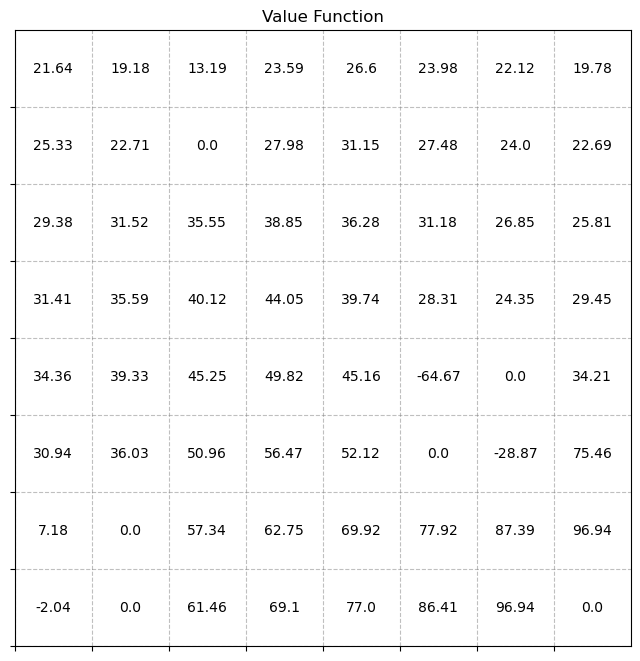

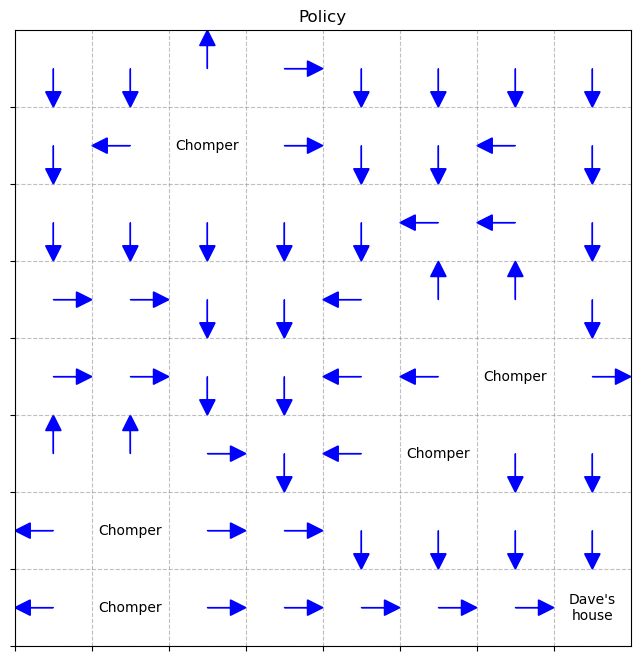

In [8]:
#First lets change the environment render mode to None for training purposes
env.render_mode = None
#Instanciate Policy iteration with theta=0.00001
policy_iteration = PolicyIteration(env, 0.00001)
#Run training for policy_iteration
policy_iteration_values, policy_iteration_policy = policy_iteration.get_training_results()
policy_iteration.visualise_values()
policy_iteration.visualise_policy()

In [9]:
#(Optional)Now lets visualize the policy in action
run_environment(env, policy=policy_iteration_policy)

### 3.2.1 Value Iteration
In this block we implement the ValueIteration algorithm

**Note:** We update the policy in each state, even though intermediate policies are not relevant so that in the final iteration we already computed the policy.

In [10]:
class ValueIteration(LearningAlgorithm):
    """
    Inherits learning algorithms and impleemnts value iteration algorithm.
    """
    def __init__(self, zombie_environment, theta):
        super().__init__(zombie_environment=zombie_environment)
        #INITIALIZE CONFIG PARAMETERS
        self.theta = theta
        #INITIALIZE POLICY PROPERTY
        self.policy = np.zeros(self.number_of_states, dtype= 'int')
        #INITIALIZE VALUE FUNCTION
        self.value_function = np.zeros(self.number_of_states)
        
    
    def single_value_iteration(self):
        """
        Implement a single value function iteration.
        Returns: delta: the value of delta after the iteration
        """
        #Initialize q values function to store the values for computing max
        new_value_function = np.zeros(self.number_of_states)
        delta = 0
        for state in range(self.number_of_states):                
            #Avoid updating the values of terminal states
            if self.zombie_environment.is_terminal(state):
                continue
            
            values = np.zeros(self.number_of_actions) #Store the values of the different actions
            for action in range(self.number_of_actions):
                value = 0
                # prob is a tuple of (transition probability, next state, reward)
                for prob in self.zombie_environment.P[state][action]:
                    value += prob[0]*(prob[2] + self.gamma*self.value_function[prob[1]]) #The value for an action
                
                values[action] = value
            #Get max value, best action and store the value and best action
            max_value = np.max(values, axis=0)
            best_action = np.argmax(values)
            self.policy[state] = best_action
            new_value_function[state] = max_value
            #update delta
            delta = max(delta, abs(self.value_function[state] - new_value_function[state]))

        #update policy
        self.value_function = new_value_function
        
        return delta
                
                
    def run_training(self):
        """
        Implement the method for running a training. Train the agent until delta is smaller or equal than theta.
        """
        #Run value iteration until convergence
        delta = self.single_value_iteration()
        while delta > self.theta:
            delta = self.single_value_iteration()

        #Given states find optimal policy
        self.trained = True


#### Example usage
The following code blocks will show the optimal policy and values on the grid.

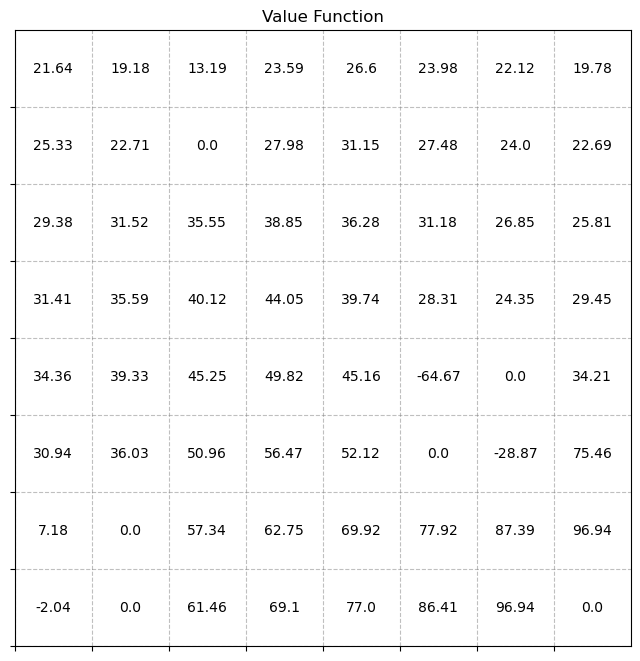

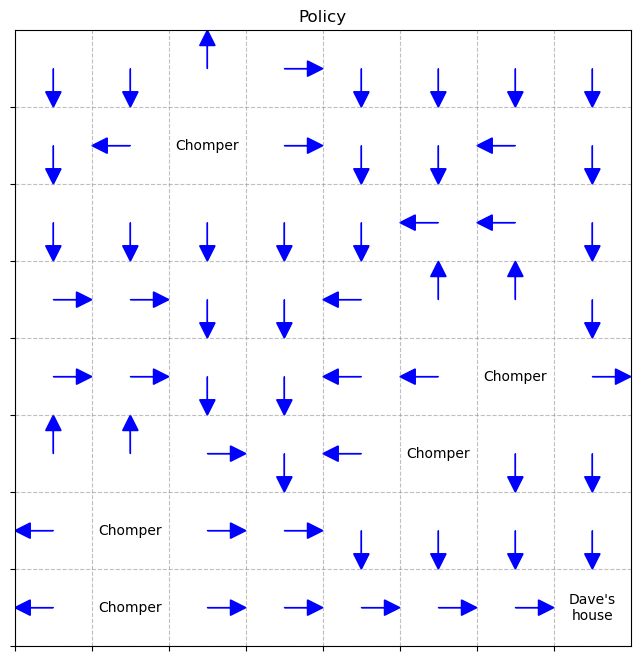

In [11]:
#First lets change the environment render mode to None for training purposes
env.render_mode = None
#Instanciate Value iteration with theta=0.00001
value_iteration = ValueIteration(env, 0.00001)
#Run training for value_iteration
value_iteration_values, value_iteration_policy = value_iteration.get_training_results()
value_iteration.visualise_values()
value_iteration.visualise_policy()

In [12]:
#(Optional)Now lets visualize the policy in action
run_environment(env, policy=value_iteration_policy)

## 3.3 Monte Carlo Methods

### 3.3.1 Base Montecarlo class
As before we implement the base montecarlo class that contains methods and properties used on the impleentations.

In [13]:
class MonteCarloLearning(LearningAlgorithm):
        
    def __init__(self, zombie_environment, max_steps=50, target_values=None, episodes=100):
        super().__init__(zombie_environment=zombie_environment)

        self.state_action_value_function = None #The action value function np array [state, action]
        self.state_action_returns = None #Sum of rewards collected for the state action pair, np array [state, action]
        self.count_state_action_visits = None #Count of visits for the state action pair, np array [state, action]
        self.max_steps = max_steps
        self.state_returns = None #Sum of rewards collected for the state action pair, np array [state, action]
        self.count_state_visits = None #Count of visits for the state action pair, np array [state, action]
        self.target_values = target_values
        self.episodes = episodes
        self.errors = np.zeros(self.episodes)

    def calculate_expected_return(self, episode, mode, gamma):
        """
        Calculate first-visit G_t recursively and update the count of visited + returns 
        
        Parameters:
        episode: a list of tuples containing the rewards.
        mode: state or state-action
        """
        #Improve efficeicncy by first doing forward pass and then check if value needs to be added
        episode_length = len(episode)
        returns = np.zeros(episode_length)
        
        G = 0

        #Backwards
        for t in range(episode_length - 1, -1, -1):
            state, action, reward = episode[t]
            G = gamma * G + reward
            returns[t] = G

        #Forward pass
        visited_states = set()
        visited_state_actions = set()

        for t, episode_step in enumerate(episode):
            
            state, action, reward = episode_step
            
            if mode == "state_value":
                if state not in visited_states:
                    visited_states.add(state)
                    self.state_returns[state] += returns[t]
                    self.count_state_visits[state] += 1

            elif mode == "state_action_value":
                if (state, action) not in visited_state_actions:
                    visited_state_actions.add((state, action))
                    self.state_action_returns[state, action] += returns[t]
                    self.count_state_action_visits[state, action] += 1


### 3.3.2 Monte Carlo Prediction

In [14]:
class MonteCarloPrediction(MonteCarloLearning):

    def __init__(self, zombie_environment, policy, episodes = 100, max_steps = 50, target_values=None):
        super().__init__(zombie_environment=zombie_environment, max_steps=max_steps, episodes=episodes, target_values=target_values)
        self.episodes = episodes
        self.policy = policy
        self.state_action_value_function = np.zeros((self.number_of_states, self.number_of_actions)) #The action value function np array [state, action]
        self.state_action_returns = np.zeros((self.number_of_states, self.number_of_actions)) #Sum of rewards collected for the state action pair, np array [state, action]
        self.count_state_action_visits = np.zeros((self.number_of_states, self.number_of_actions), dtype='int') #Count of visits for the state action pair, np array [state, action]

    
    def run_training(self):
        """
        Process:

        1 - For each episode do.
            1- random initial state selection 
            2 - episode generation based on policy and initial state
            3 - update the count and sum rewards (calling g unction with mode)
            
        2 - compute average
        
        """
        for episode_number in range(self.episodes):
            #Only generate complete episodes for monte carlo methods
            truncated = True
            while truncated:
                # Generate a random non-terminal starting state and random action
                random_state = np.random.randint(0, self.number_of_states)
                while self.zombie_environment.is_terminal(random_state):
                    random_state = np.random.randint(0, self.number_of_states)

                random_action = np.random.randint(0, self.number_of_actions)

                # generate an episode starting at the random starting state and following the policy
                episode, truncated = self.zombie_environment.generate_episode(policy=self.policy, initial_state=random_state, initial_action=random_action, max_steps=self.max_steps)
                
            # update count and reward using calculate_expected_return
            self.calculate_expected_return(episode=episode, gamma=self.gamma, mode="state_action_value")
           
            self.state_action_value_function = np.divide(
                self.state_action_returns, 
                self.count_state_action_visits,
                out=self.state_action_value_function,
                where=self.count_state_action_visits>0
            )

            self.value_function = np.max(self.state_action_value_function, axis=1)

            
            if self.target_values is not None:
                self.store_error(episode_number)

            print(f"Episode: {episode_number}")


### 3.3.3 Monte Carlo Control
Implement Monte Carlo control with exploring starts

**Notes on implementation:** Some episodes where taking too long to run becaus the agent kept on running around. This led to performance issues so it is posible to fix a max_steps for the episodes which results in increased performance.

In [15]:
class MonteCarloControl(MonteCarloLearning):

    def __init__(self, zombie_environment, episodes = 100, max_steps = 50, target_values=None):
        super().__init__(zombie_environment = zombie_environment, max_steps=max_steps, target_values=target_values, episodes=episodes)
        self.episodes = episodes
        self.policy = np.zeros(self.number_of_states, dtype='int')

        self.state_action_value_function = np.zeros((self.number_of_states, self.number_of_actions)) #The action value function np array [state, action]
        self.state_action_returns = np.zeros((self.number_of_states, self.number_of_actions)) #Sum of rewards collected for the state action pair, np array [state, action]
        self.count_state_action_visits = np.zeros((self.number_of_states, self.number_of_actions), dtype='int') #Count of visits for the state action pair, np array [state, action]

    
    def run_training(self):
        """
        Init:
        random policy for non terminal states
        q(s, a) init in 0
        initialize returns matrix

        Process:

        1 - Choose random start from non terminal states.
        2 - Choose random initial action
        3 - Generate random episode following policy and with inital states
        4 - run the function for calculating returns
        5 - update policy.
        """


        for episode_number in tqdm(range(self.episodes)):
            #Only generate complete episodes for monte carlo methods, avoid them being too long
            truncated = True
            while truncated:
                #Generate random state that is not terminal
                random_state = np.random.randint(0, self.number_of_states)
                while self.zombie_environment.is_terminal(random_state):
                    random_state = np.random.randint(0, self.number_of_states)
                
                random_action = np.random.randint(0, self.number_of_actions)
                # generate episode with random start
                episode, truncated = self.zombie_environment.generate_episode(policy=self.policy, initial_state=random_state, initial_action=random_action, max_steps=self.max_steps)
                # update count and reward using calculate_expected_return
            
            self.calculate_expected_return(episode=episode, gamma=self.gamma, mode="state_action_value")
            
            self.state_action_value_function = np.divide(
                self.state_action_returns, 
                self.count_state_action_visits,
                out=self.state_action_value_function,
                where=self.count_state_action_visits>0
            )

            self.value_function = np.max(self.state_action_value_function, axis=1)
            self.policy = np.argmax(self.state_action_value_function, axis=1)

            # Every x episodes calculate the cumulative reward of the current policy
            if episode_number % round(self.episodes / 1000) == 0:
                self.calc_policy_reward(episode_n=episode_number)
            
            if self.target_values is not None:
                self.store_error(episode_number)

#### Example usage
The following code blocks will run the montecarlo control training for 1 million episodes. The target value is set as the values obtained by the policy iteration algorithm which we use as ground truth for evaluation.

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000000/1000000 [04:16<00:00, 3891.89it/s]


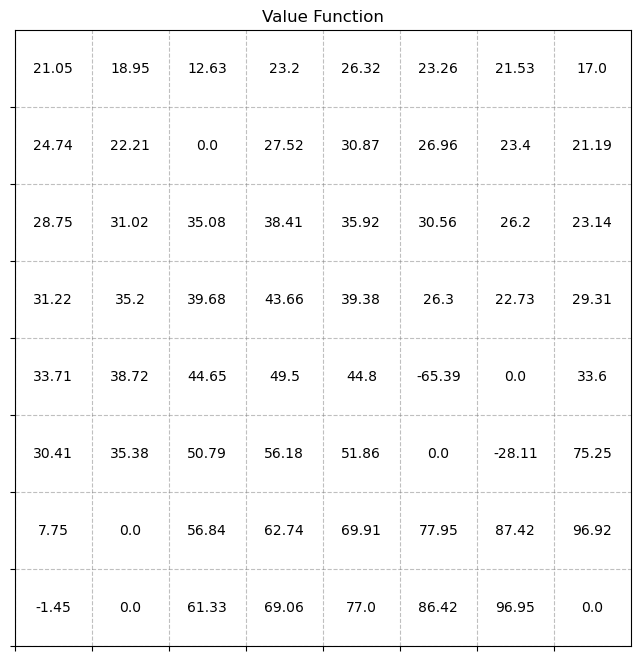

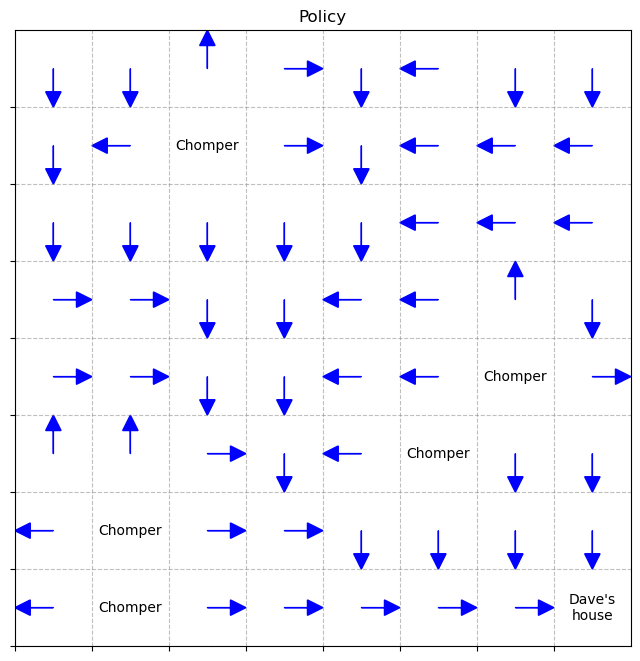

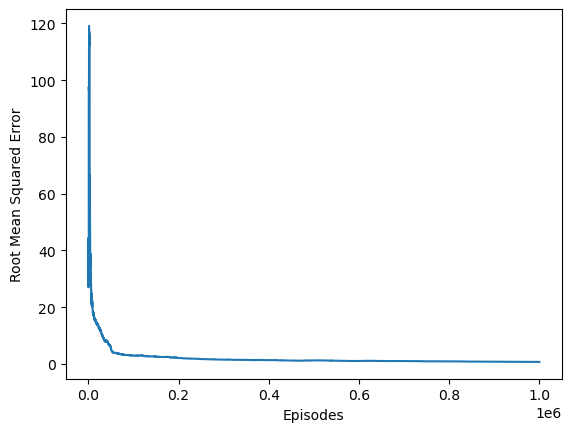

In [16]:
#First lets change the environment render mode to None for training purposes
env.render_mode = None
#Instanciate MonteCarloControl class
mc_control = MonteCarloControl(zombie_environment=env, episodes=1000000, max_steps=100, target_values=policy_iteration_values)
mc_control_values, mc_control_policy = mc_control.get_training_results()
mc_control.visualise_values()
mc_control.visualise_policy()
mc_control.plot_error()

In [17]:
#(Optional)Now lets visualize the policy in action
run_environment(env, policy=mc_control_policy)

## 3.4 Temporal Difference Methods

### 3.4.1 TD Prediction Algorithm

In [18]:
class TD_Prediction(LearningAlgorithm):
    def __init__(self, zombie_environment:ZombieEscapeEnv, alpha, policy, episodes = 1000, target_values=None):
        super().__init__(zombie_environment=zombie_environment)
        self.episodes = episodes
        self.alpha = alpha
        self.policy = policy
        self.target_values = target_values
        self.errors = np.zeros(self.episodes)
        #initial state, action values
        self.Q_S_A = np.zeros((self.number_of_states, self.number_of_actions))
        
        
        
        
    def run_training(self):
        for episode in range(self.episodes):
            state, info = self.zombie_environment.reset()
            terminated =  False
            action = self.policy[state]
            
            while not terminated:
                next_state, reward, terminated = self.zombie_environment.step(action)[:3]
                next_action = self.policy[next_state]
                self.Q_S_A[state][action] += self.alpha * (reward + self.gamma * self.Q_S_A[next_state][next_action] -  self.Q_S_A[state][action])
                state, action = next_state, next_action

            self.value_function = np.max(self.Q_S_A, axis=1)
            if self.target_values is not None:
                self.store_error(episode)

### 3.4.2 TD SARSA Algorithm

In [22]:
class SARSA(LearningAlgorithm):
    def __init__(self, zombie_environment:ZombieEscapeEnv, episodes = 1000, alpha = 0.1, target_values=None, decrease_rate=10):
        super().__init__(zombie_environment=zombie_environment)
        self.episodes = episodes
        self.alpha = alpha
        self.zombie_environment = zombie_environment
        self.target_values = target_values
        self.errors = np.zeros(self.episodes)
        self.decrease_rate = decrease_rate
      
        #initial state, action values
        self.Q_S_A = np.zeros((self.number_of_states, self.number_of_actions))
            
            
    
    
    
    def epsilon_policy(self, epsilon, Q_S_A, state, env):
        '''
        Applying epsilon greedy stratgy,
        return the corresponding action given current epsilon
        '''
        prob = random.uniform(0, 1)
        if prob < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(Q_S_A[state])
        return action
   


    def run_training(self):
        for episode in tqdm(range(self.episodes)):
            #restrat the environment after every episode
            state = self.zombie_environment.reset()
            epsilon =  np.exp(-self.decrease_rate/self.episodes*episode)                  
            action = self.epsilon_policy(epsilon, self.Q_S_A, state, self.zombie_environment)
            terminated = False
            

            while not terminated:
                next_state, reward, terminated = self.zombie_environment.step(action)[:3]
                next_action = self.epsilon_policy(epsilon, self.Q_S_A, next_state, self.zombie_environment)
                #Apply sarsa state action update function
                self.Q_S_A[state][action] += self.alpha * (reward + self.gamma * self.Q_S_A[next_state][next_action] -  self.Q_S_A[state][action])                    
                #update state action for the next step of episode    
                state, action = next_state, next_action
                
            # Every x episodes calculate the cumulative reward of the current policy
            """if episode % 100 == 0:
                self.policy = np.argmax(self.Q_S_A, axis=1)
                self.calc_policy_reward(episode_n = episode)"""
                 
            #Get the value table after each episode
            self.value_function = np.max(self.Q_S_A, axis = 1)
            
            if self.target_values is not None:
                self.store_error(episode)
                
            self.policy = np.argmax(self.Q_S_A, axis=1)
        return self.Q_S_A, self.policy



#### Example usage
The following code blocks will run the montecarlo control training for 1 million episodes. The target value is set as the values obtained by the policy iteration algorithm which we use as ground truth for evaluation..

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:29<00:00, 337.42it/s]


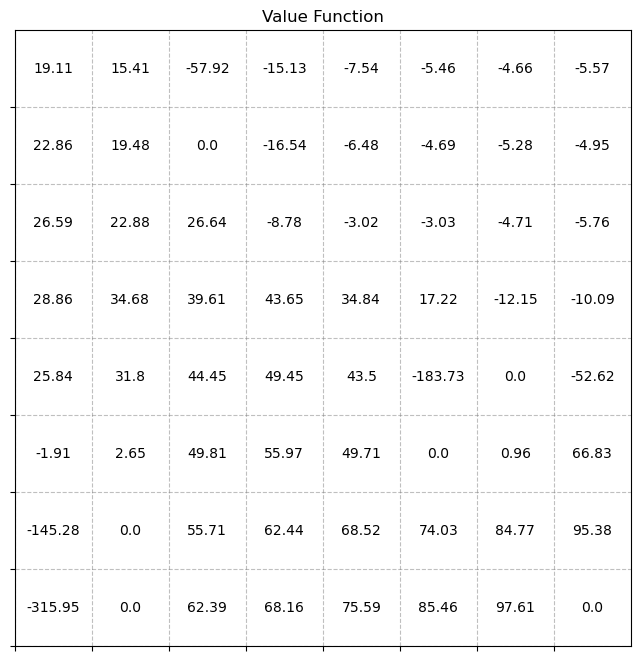

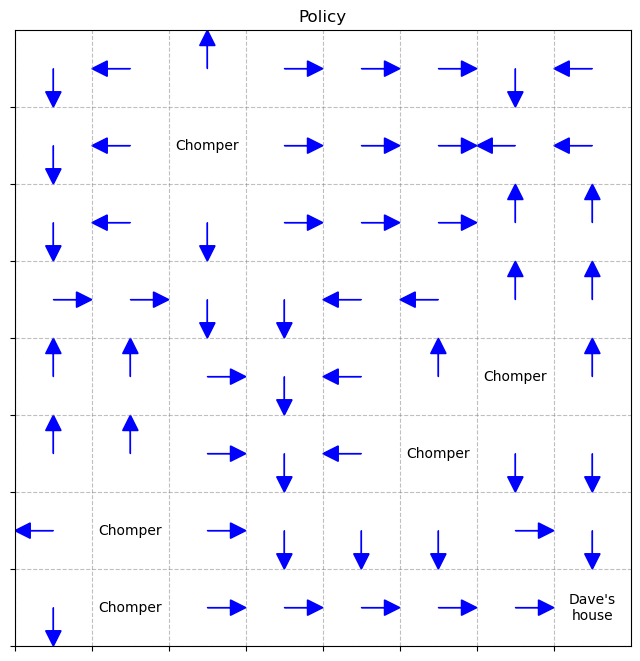

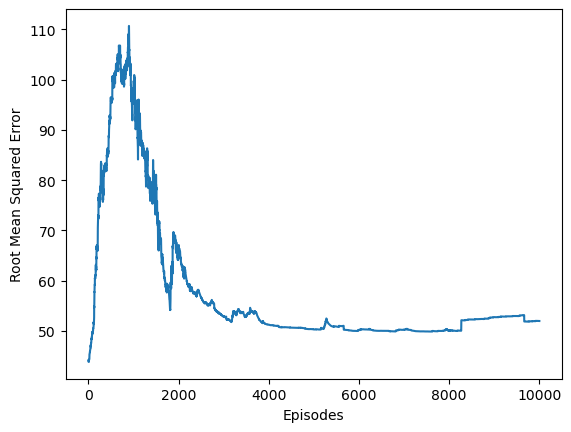

In [25]:
#First lets change the environment render mode to None for training purposes
env.render_mode = None
#Instanciate SARSA class
sarsa = SARSA(zombie_environment=env, episodes=10000, alpha=0.1, target_values=policy_iteration_values, decrease_rate=10)
sarsa_values, sarsa_policy = sarsa.get_training_results()
sarsa.visualise_values()
sarsa.visualise_policy()
sarsa.plot_error()

In [26]:
#(Optional)Now lets visualize the policy in action
run_environment(env, policy=sarsa_policy)

In [27]:
### 3.4.3 TD Q-Learning Algorithm

In [28]:
class TDQLearning(LearningAlgorithm):
    def __init__(self, zombie_environment: ZombieEscapeEnv,
                 episodes = 100000, alpha = 0.05, epsilon_start = 0.9, epsilon_end = 0.1, target_values = None):
        super().__init__(zombie_environment)
        self.zombie_environment = zombie_environment
        self.episodes = episodes
        self.gamma = zombie_environment.get_gamma()
        self.alpha = alpha
        self.epsilon_start = epsilon_start
        self.epsilon_end = epsilon_end
        self.epsilon = epsilon_start

        self.qsa = np.zeros((self.zombie_environment.observation_space.n, self.zombie_environment.action_space.n))
        self.policy = np.zeros(self.zombie_environment.observation_space.n)

        self.target_values = target_values
        self.errors = np.zeros(self.episodes)

    @staticmethod
    def epsilon_policy(epsilon, Q_S_A, state, env):
        """Choose random action or best action (according to QSA) based on random chance and epsilon"""
        prob = random.uniform(0, 1)
        if prob < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(Q_S_A[state])
        return action

    def new_epsilon(self, episode_number):
        """Calculate epsilon for certain episode number based on decreasing (liner) epsilon formula"""
        self.epsilon = max(self.epsilon_end,
                           self.epsilon_start - episode_number / self.episodes * (self.epsilon_start - self.epsilon_end))

    def run_training(self):
        for episode in tqdm(range(self.episodes)):
            state = self.zombie_environment.reset()

            terminated = False
            while not terminated:
                # Choose and execute action using epsilon greedy policy
                action = self.epsilon_policy(self.epsilon, self.qsa, state, env=self.zombie_environment)
                next_state, reward, terminated = self.zombie_environment.step(action)[:3]

                # Update q values according to update rule
                self.qsa[state, action] += self.alpha * (reward + self.gamma * np.max(self.qsa[next_state]) - self.qsa[state, action])

                # Update current state to next state
                state = next_state

            # Every x episodes calculate the cumulative reward of the current policy
            if episode % 100 == 0:
                self.policy = np.argmax(self.qsa, axis=1)
                self.calc_policy_reward(episode_n = episode)

            # Calculate the value matrix and compare it target values to caclulate RMS
            self.value_function = np.max(self.qsa, axis=1)
            if self.target_values is not None:
                self.store_error(episode)

            # TODO: Better epsilon function, since it's currently under-performing a static epsilon
            self.new_epsilon(episode)

        # Calculate the final policy matrix and value matrix
        self.policy = np.argmax(self.qsa, axis=1)
        self.value_function = np.max(self.qsa, axis=1)


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [01:22<00:00, 1207.99it/s]


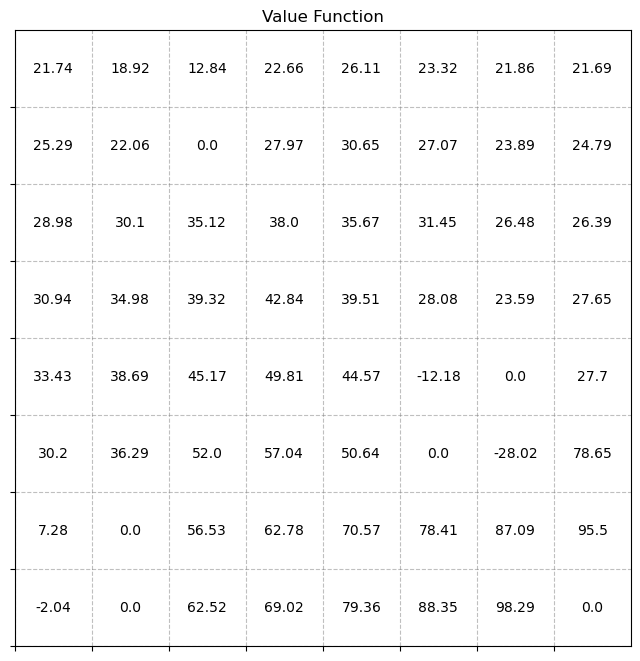

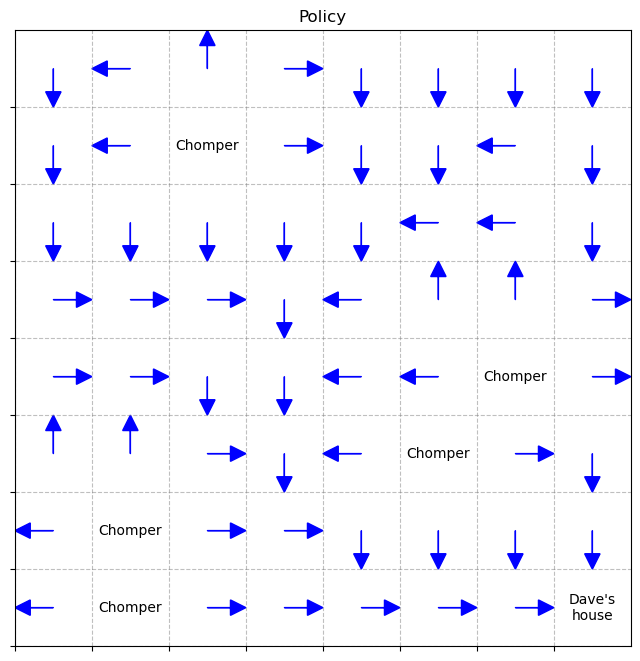

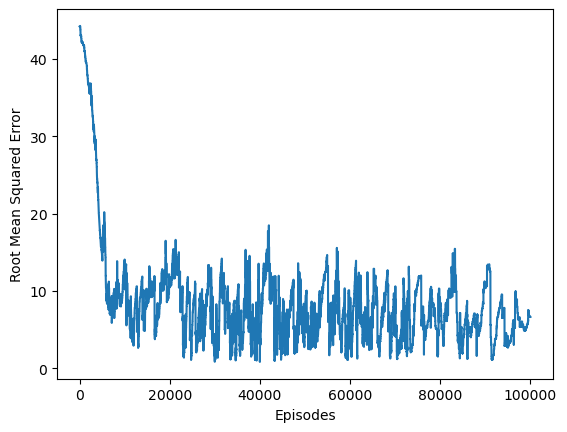

In [30]:
#First lets change the environment render mode to None for training purposes
env.render_mode = None
#Instanciate Q-Learning class
q_learning = TDQLearning(zombie_environment=env, episodes=100000, alpha=0.05, target_values=policy_iteration_values)
q_learning_values, q_learning_policy = q_learning.get_training_results()
q_learning.visualise_values()
q_learning.visualise_policy()
q_learning.plot_error()

In [31]:
#(Optional)Now lets visualize the policy in action
run_environment(env, policy=q_learning_policy)

In [ ]:
def compare_algs(alg_list: List[LearningAlgorithm]):
    # Check if all algs have same amount of episodes
    episode_amount = alg_list[0].episodes
    for alg in alg_list[1::]:
        assert alg.episodes == episode_amount, "Episode amount should be equal for all algorithms to plot difference"

    # Train all algs
    for alg in alg_list:
        print(f"Now training: {alg}")
        alg.get_training_results()

    # Plot errors for all algs
    index = range(len(alg_list[0].errors))
    for alg in alg_list:
        plt.plot(index, alg.errors, label=f"{type(alg).__name__}")

    # Labels and visualisation
    plt.xlabel('Episodes')
    plt.ylabel('Root Mean Squared Error')
    plt.title("RMSE values in Q-Learning for different alphas")
    plt.legend(title="Algorithms")
    plt.show()
